In [62]:
from coniii import *
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random

# Generate neural arrays and generationof sets of random assemblies

## How to generate neural arrays
    1. Generate a hexagonal lattice of unit spacing, in which a neuron was placed at every lattice point.
    2. Draw points to get an assembly by:
        (1) Random generate points.
        (2) Calculate closest neural
        (3) If the distance smaller than a throshold, get that neural into assemblies

**To do: Add algorithm to control overlap rate**

In [87]:
# define parameters
T = 3600 # time of simulation
N = 81  # number of neurons
dT = 0.5 # time step
params_assembly_density = 4 # size of neurons in each assembly
params_assembly_num = 10 # number of assemblies
params_point_into_neuron_distance = 0.5
fire_rate_background = np.random.uniform(1, 6, N)

In [64]:
# Function to create a neuron array using unit-spacing hexagonal lattice points
def create_neuron_array(num_neurons):
    coords = []
    num_rows = int(np.sqrt(num_neurons))
    num_cols = num_rows
    for i in range(num_rows):
        for j in range(num_cols):
            x = j + 0.5 * (i % 2)  # Stagger every other row to create hexagonal pattern
            y = i * np.sqrt(3) / 2  # Scale row spacing by sqrt(3)/2 to create hexagonal pattern
            coords.append((x, y))
    return np.array(coords)

In [83]:
# Function to create an assembly of neurons
def create_assembly(neuron_coords, num_points, mean, std_dev):
    # Create the covariance matrix
    cov_matrix = np.eye(2) * std_dev**2
    # Draw points from a two-dimensional normal distribution
    points = np.random.multivariate_normal(mean, cov_matrix, num_points)
    # Find the closest neuron to each drawn point
    distances = cdist(points, neuron_coords)
    closest_neurons = np.argmin(distances, axis=1)
    # If the distance from the neuron to the drawn point is less than 0.5, it is considered part of the assembly
    assembly_neurons = neuron_coords[closest_neurons[distances[np.arange(len(closest_neurons)), closest_neurons] < 0.5]]
    print("Number of neurons in assembly: ", len(assembly_neurons))
    print("Neurons in assembly:\n ", assembly_neurons)
    return assembly_neurons

Centre:  [3.88251843 4.27490284]
Standard deviation:  [20.8889832  20.91921522]
Points in assembly:
  [[3.92093558 3.73620069]
 [3.41215707 4.4352694 ]
 [5.80764474 5.65728445]
 [3.11099689 4.25516909]]
Number of neurons in assembly:  4
Neurons in assembly:
  [[4.         3.46410162]
 [3.5        4.33012702]
 [6.         5.19615242]
 [3.5        4.33012702]]
Points in assembly:
  [[5.75452546 4.8479866 ]
 [5.68866799 3.60438839]
 [4.214557   4.6130501 ]
 [5.50393947 4.57392511]]
Number of neurons in assembly:  4
Neurons in assembly:
  [[6.         5.19615242]
 [6.         3.46410162]
 [4.5        4.33012702]
 [5.5        4.33012702]]
Points in assembly:
  [[3.61336203 4.1989862 ]
 [3.51321521 3.06298066]
 [3.37231143 4.95360781]
 [4.18896621 5.55315146]]
Number of neurons in assembly:  4
Neurons in assembly:
  [[3.5        4.33012702]
 [3.5        2.59807621]
 [3.         5.19615242]
 [4.         5.19615242]]
Points in assembly:
  [[3.07859799 4.45815169]
 [3.79854052 4.02378291]
 [4.5

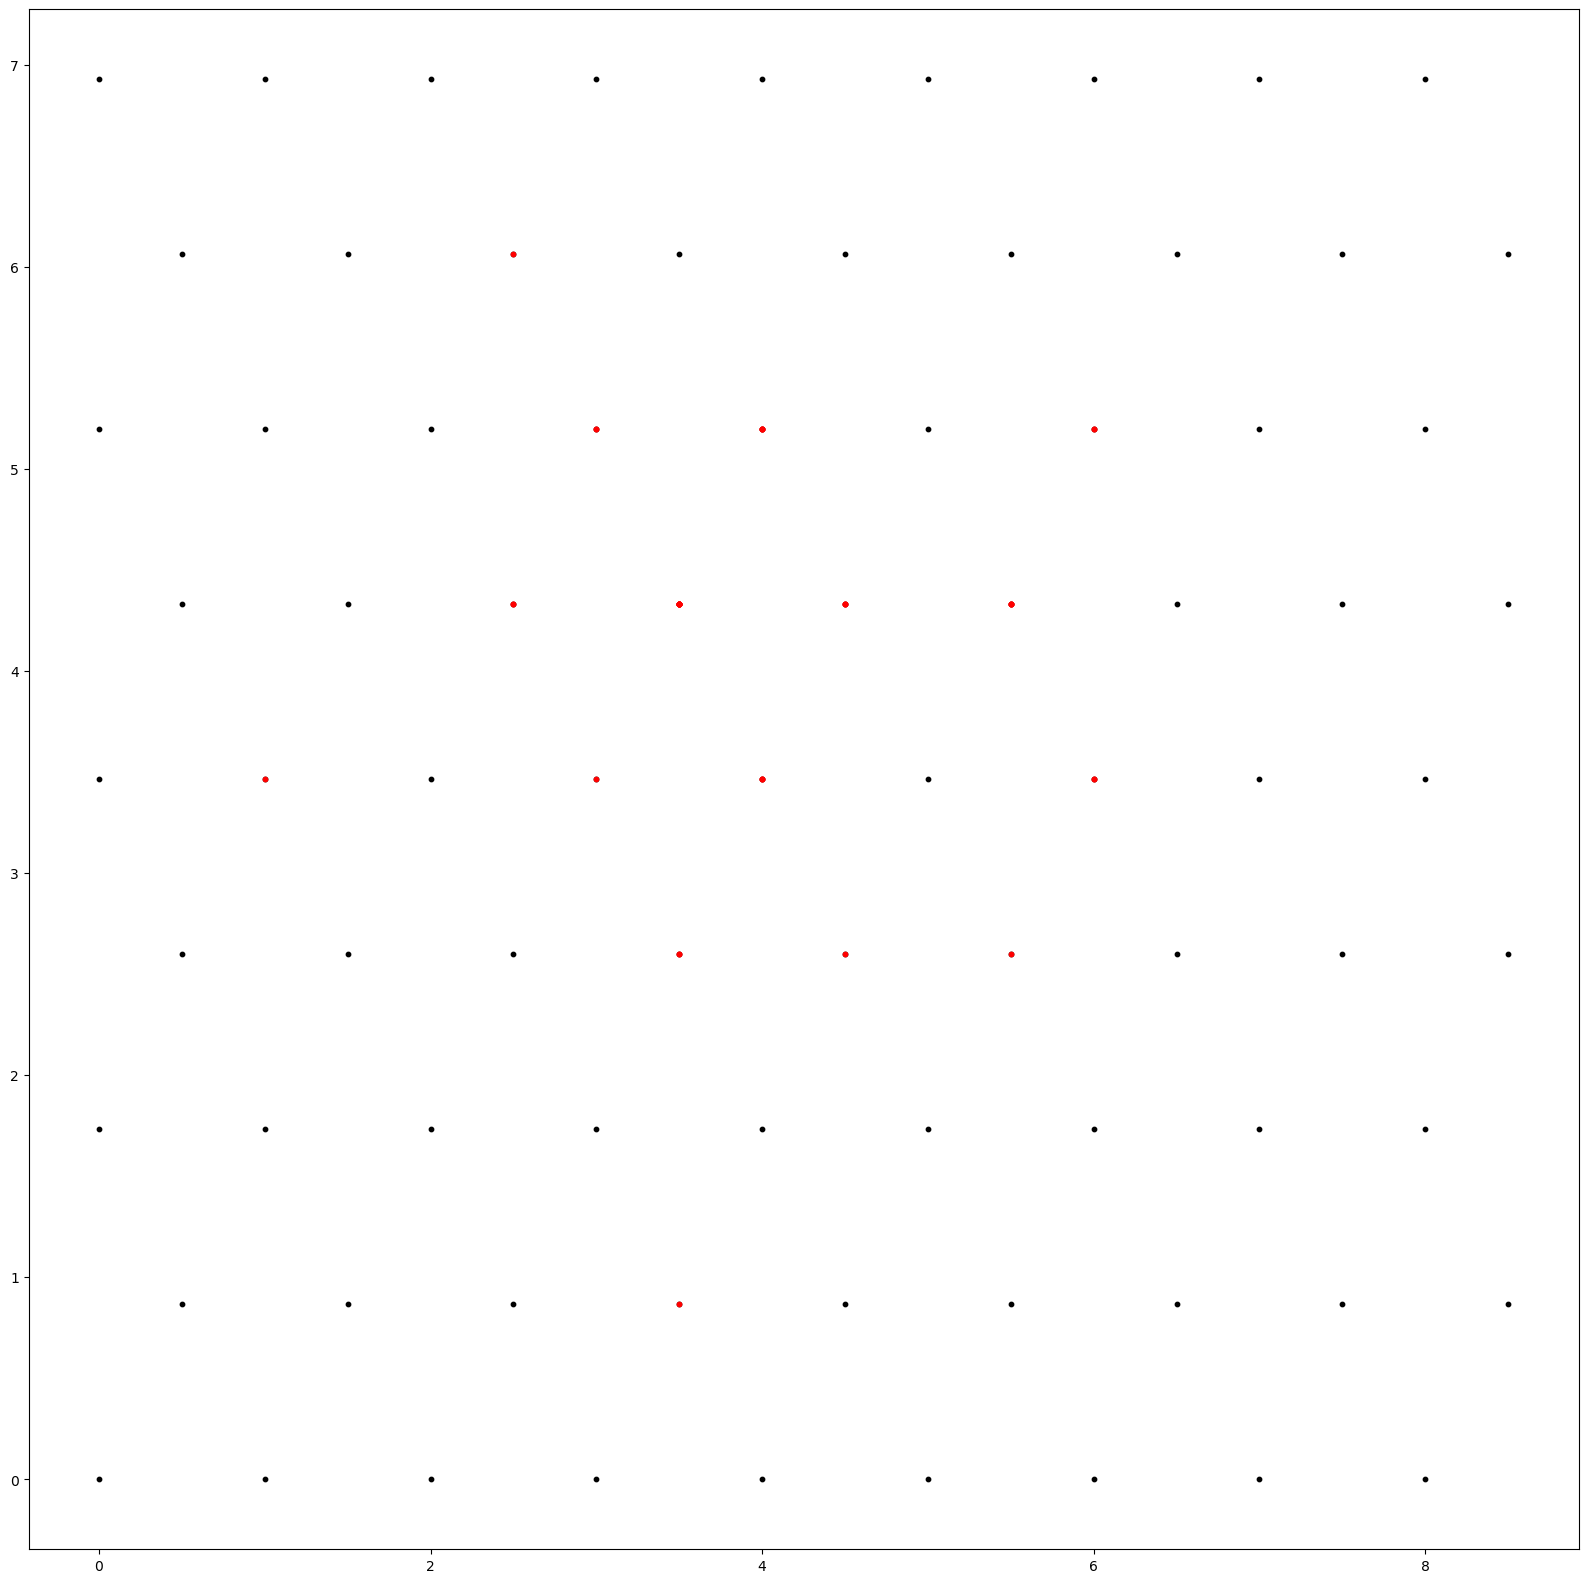

In [84]:
# Choose a centre from a uniform distribution
params_distruibution_centre = np.random.uniform(3.5, 4.5, size=2)
# Choose a standard deviation from a uniform distribution
params_distribution_std_dev = np.random.uniform(20, 21, size=2)

print("Centre: ", params_distruibution_centre)
print("Standard deviation: ", params_distribution_std_dev)

# Generate the neuron array
neuron_array = create_neuron_array(N)


# Generate assemblies
assemblies = []
for i in range(params_assembly_num):
    centre = np.random.uniform(-4, 4, size=2)
    assembly = create_assembly(neuron_array,params_assembly_density ,params_distruibution_centre, 1)
    assemblies.append(assembly)

# Plot the neuron array and assemblies
plt.figure(figsize=(20, 20))
plt.scatter(neuron_array[:, 0], neuron_array[:, 1], color='black', s=10)
for assembly in assemblies:
    plt.scatter(assembly[:, 0], assembly[:, 1], color='red', s=10)
plt.show()



## Simulation of population calcium fluorescence activity

### Assign firing rate for each neuron
    1. Every neuron have a background firing rate independently and uniformly from range R
    2. At each time t, every neuron n had a probability 


In [85]:
import numpy as np
from scipy.stats import poisson

def generateSpikeCountField(N, T, dT, assemblies, rateRange, eventDur, eventProb, eventMult):
    
    """
    Function to generate spike count for a given set of parameters.
    N: Number of neurons
    T: Number of time steps
    dT: Width of a time step in units of seconds
    assemblies: List of collections of units to be combined to assemblies
    rateRange: Range of base firing rate in units of inverse seconds (Hertz)
    eventDur: Length of an active event as a number of timesteps
    eventProb: Probability with which a unit is particularly active in a single timestep
    eventMult: Firing rate multiplier at active events
    """
    
    # Get time flame count
    flames = int(T/dT)

    # Initialize a field of activation event indicators
    activation_field = np.zeros((flames, N), dtype=bool)

    # At beginning of simulation, all neurons have an background firing rate
    activation_field[0, :] = np.random.rand(N) < fire_rate_background * dT

    # Set the firing rate multiplier for each timestep
    fire_rate = np.zeros(flames(flames, N))
    fire_rate[0, :] = fire_rate_background

    """
    To do: 
    1.change the assembly to a list of neurons
                给neuron编号，然后用编号来表示assembly
    2.对于每个time flame，计算neuron是否被激活。
            计算neuron是否被激活的方法是:
                对于assembly中的neuron，如果这个assembly中有一个neuron被激活了，那么这个assembly中的所有neuron都会被激活
                对于不在任何assembly中的neuron，如果这个neuron被激活了，那么这个neuron就会被激活
    3.如果neuron在某个状态被激活，就在前一个time flame的firing rate上以eventProb的概率增加eventMult倍的firing rate.
    4.利用poisson分布来计算t时间段的neuron的spike count：
        spike count = poisson(firing rate * dT)
    """

    # For each time flame, get the number of firing rate
    for i in range(flames):
        if i == 0:
            fire_rate[0, :] = fire_rate_background
        else:
            # For each assembly, determine which neurons have an activation event
            for assembly in assemblies:
                activation_field[i, assembly] = np.random.rand(len(assembly)) < eventProb
                

        
    
    
    # For each assembly, determine which neurons have an activation event
    
    
    # For neurons not in any assembly, determine if they have an activation event
    a = list(set(range(N)) - set(np.concatenate(assemblies)))
    activation_field[:, a] = np.random.rand(T, len(a)) < eventProb
    
    # If an event lasts for more than one timestep, extend the activation field
    if eventDur > 1:
        for m in range(1, int(eventDur)):
            activation_field[:-m, :] = np.logical_or(activation_field[:-m, :], activation_field[m:, :])
        frac_eventDur = eventDur - int(eventDur)
        activation_field[:-int(eventDur), :] = np.logical_or(activation_field[:-int(eventDur), :], np.random.rand(T-int(eventDur), N) < frac_eventDur)
    
    # Generate a field of firing rates
    firingrate_field = np.random.uniform(rateRange[0], rateRange[1], size=(T, N))
    
    # Increase firing rates for activation events
    firingrate_field[activation_field] *= eventMult
    
    # Generate spike counts using a Poisson distribution
    spikecount_field = poisson.rvs(firingrate_field * dT)
    
    return spikecount_field


In [91]:

# Length of an active event as a number of timesteps
eventDur = np.random.randint(1, 10)

# Probability with which a unit is particularly active in a single timestep
eventProb = np.random.rand()  # random number between 0 and 1

# Firing rate multiplier at active events
eventMult = np.random.uniform(1, 5)  # random number between 1 and 5

print(f'eventDur: {eventDur}, eventProb: {eventProb}, eventMult: {eventMult}')

generateSpikeCountField(N, T, dT, assemblies, (0.1, 0.15), eventDur, eventProb, eventMult)

eventDur: 2, eventProb: 0.591081640701251, eventMult: 4.186066550839216


Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/test/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/test/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined


IndexError: arrays used as indices must be of integer (or boolean) type

In [94]:
for assembly in assemblies:
    print(assembly)
    print(np.random.rand(len(assembly)))
    print(np.random.rand(len(assembly)) < eventProb)

[[4.         3.46410162]
 [3.5        4.33012702]
 [6.         5.19615242]
 [3.5        4.33012702]]
[0.72756328 0.43499309 0.34048068 0.39065939]
[False  True  True False]
[[6.         5.19615242]
 [6.         3.46410162]
 [4.5        4.33012702]
 [5.5        4.33012702]]
[0.06685376 0.60311962 0.53336683 0.69690122]
[ True False  True  True]
[[3.5        4.33012702]
 [3.5        2.59807621]
 [3.         5.19615242]
 [4.         5.19615242]]
[0.20125062 0.7600405  0.41952138 0.20841626]
[False False False  True]
[[3.5        4.33012702]
 [3.5        4.33012702]
 [4.5        4.33012702]
 [2.5        6.06217783]]
[0.11412007 0.42887817 0.75803691 0.54012703]
[ True  True  True  True]
[[1.         3.46410162]
 [5.5        2.59807621]
 [4.         3.46410162]
 [6.         3.46410162]]
[0.75078224 0.57325002 0.84812261 0.49518613]
[ True  True  True False]
[[4.         5.19615242]
 [3.5        4.33012702]
 [4.         5.19615242]]
[0.84658284 0.03930911 0.75055483]
[ True  True False]
[[3.